In [1]:
import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt
import corner

In [2]:
import jax 
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax.nn import relu, elu
import optax 

from jax import random

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [3]:
data = pd.read_csv('Data/mesa_data.csv')
data.head()

Unnamed: 0  filename  model_number  evol_stage  initial_mass  \
0           0  profile4         152.0         0.0           0.8   
1           1  profile5         153.0         0.0           0.8   
2           2  profile6         154.0         0.0           0.8   
3           3  profile7         155.0         0.0           0.8   
4           4  profile8         156.0         0.0           0.8   

   initial_Yinit  initial_Zinit  initial_feh  initial_MLT  initial_fov  ...  \
0           0.32       0.036803          0.5          2.1          0.0  ...   
1           0.32       0.036803          0.5          2.1          0.0  ...   
2           0.32       0.036803          0.5          2.1          0.0  ...   
3           0.32       0.036803          0.5          2.1          0.0  ...   
4           0.32       0.036803          0.5          2.1          0.0  ...   

     E_0_36    E_0_37    E_0_38        E_0_39        E_0_40        tau_he  \
0  0.000006  0.000002  0.000001  7.889056e-07  6.149682e-07  15247.850269   
1  0.000008  0.000002  0.000001  8.212464e-07  6.273383e-07  14809.891105   
2  0.000013  0.000003  0.000001  8.515127e-07  6.398741e-07  14496.838617   
3  0.000018  0.000003  0.000001  8.790797e-07  6.513090e-07  14220.559706   
4  0.000027  0.000003  0.000001  9.036751e-07  6.612813e-07  14054.932771   

      delta_he    amp_he        tau_cz  \
0  2037.139686  0.029961  38796.631185   
1  1980.528826  0.029540  37900.327592   
2  1940.585790  0.029221  37222.634389   
3  1878.217087  0.028561  36703.539749   
4  1883.449431  0.028860  36302.082709   

                                            dirname  
0  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  
1  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  
2  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  
3  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  
4  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  

[5 rows x 116 columns]

In [4]:
print(len(data))
data = data[data.star_age > 0.2]
data = data[data.effective_T < 6800]
data = data[data.nu_max > 600]
len(data)

253072


59785

In [5]:
icols = ['initial_mass',
 'initial_Yinit',
 'initial_feh',
 'initial_MLT',
 'frac_age']

ocols = ['luminosity',
 'radius',
 'delta_nu',
 'nu_max']

fcols = [f'nu_0_{n}' for n in range(12, 28)]

cols = fcols + icols + ocols

dfc = data.copy()
dfc.loc[:, ocols + fcols] = onp.log10(data[ocols + fcols])
dfc = dfc[cols]

In [6]:
xs = dfc[icols].values
ys = dfc[fcols + ocols].values

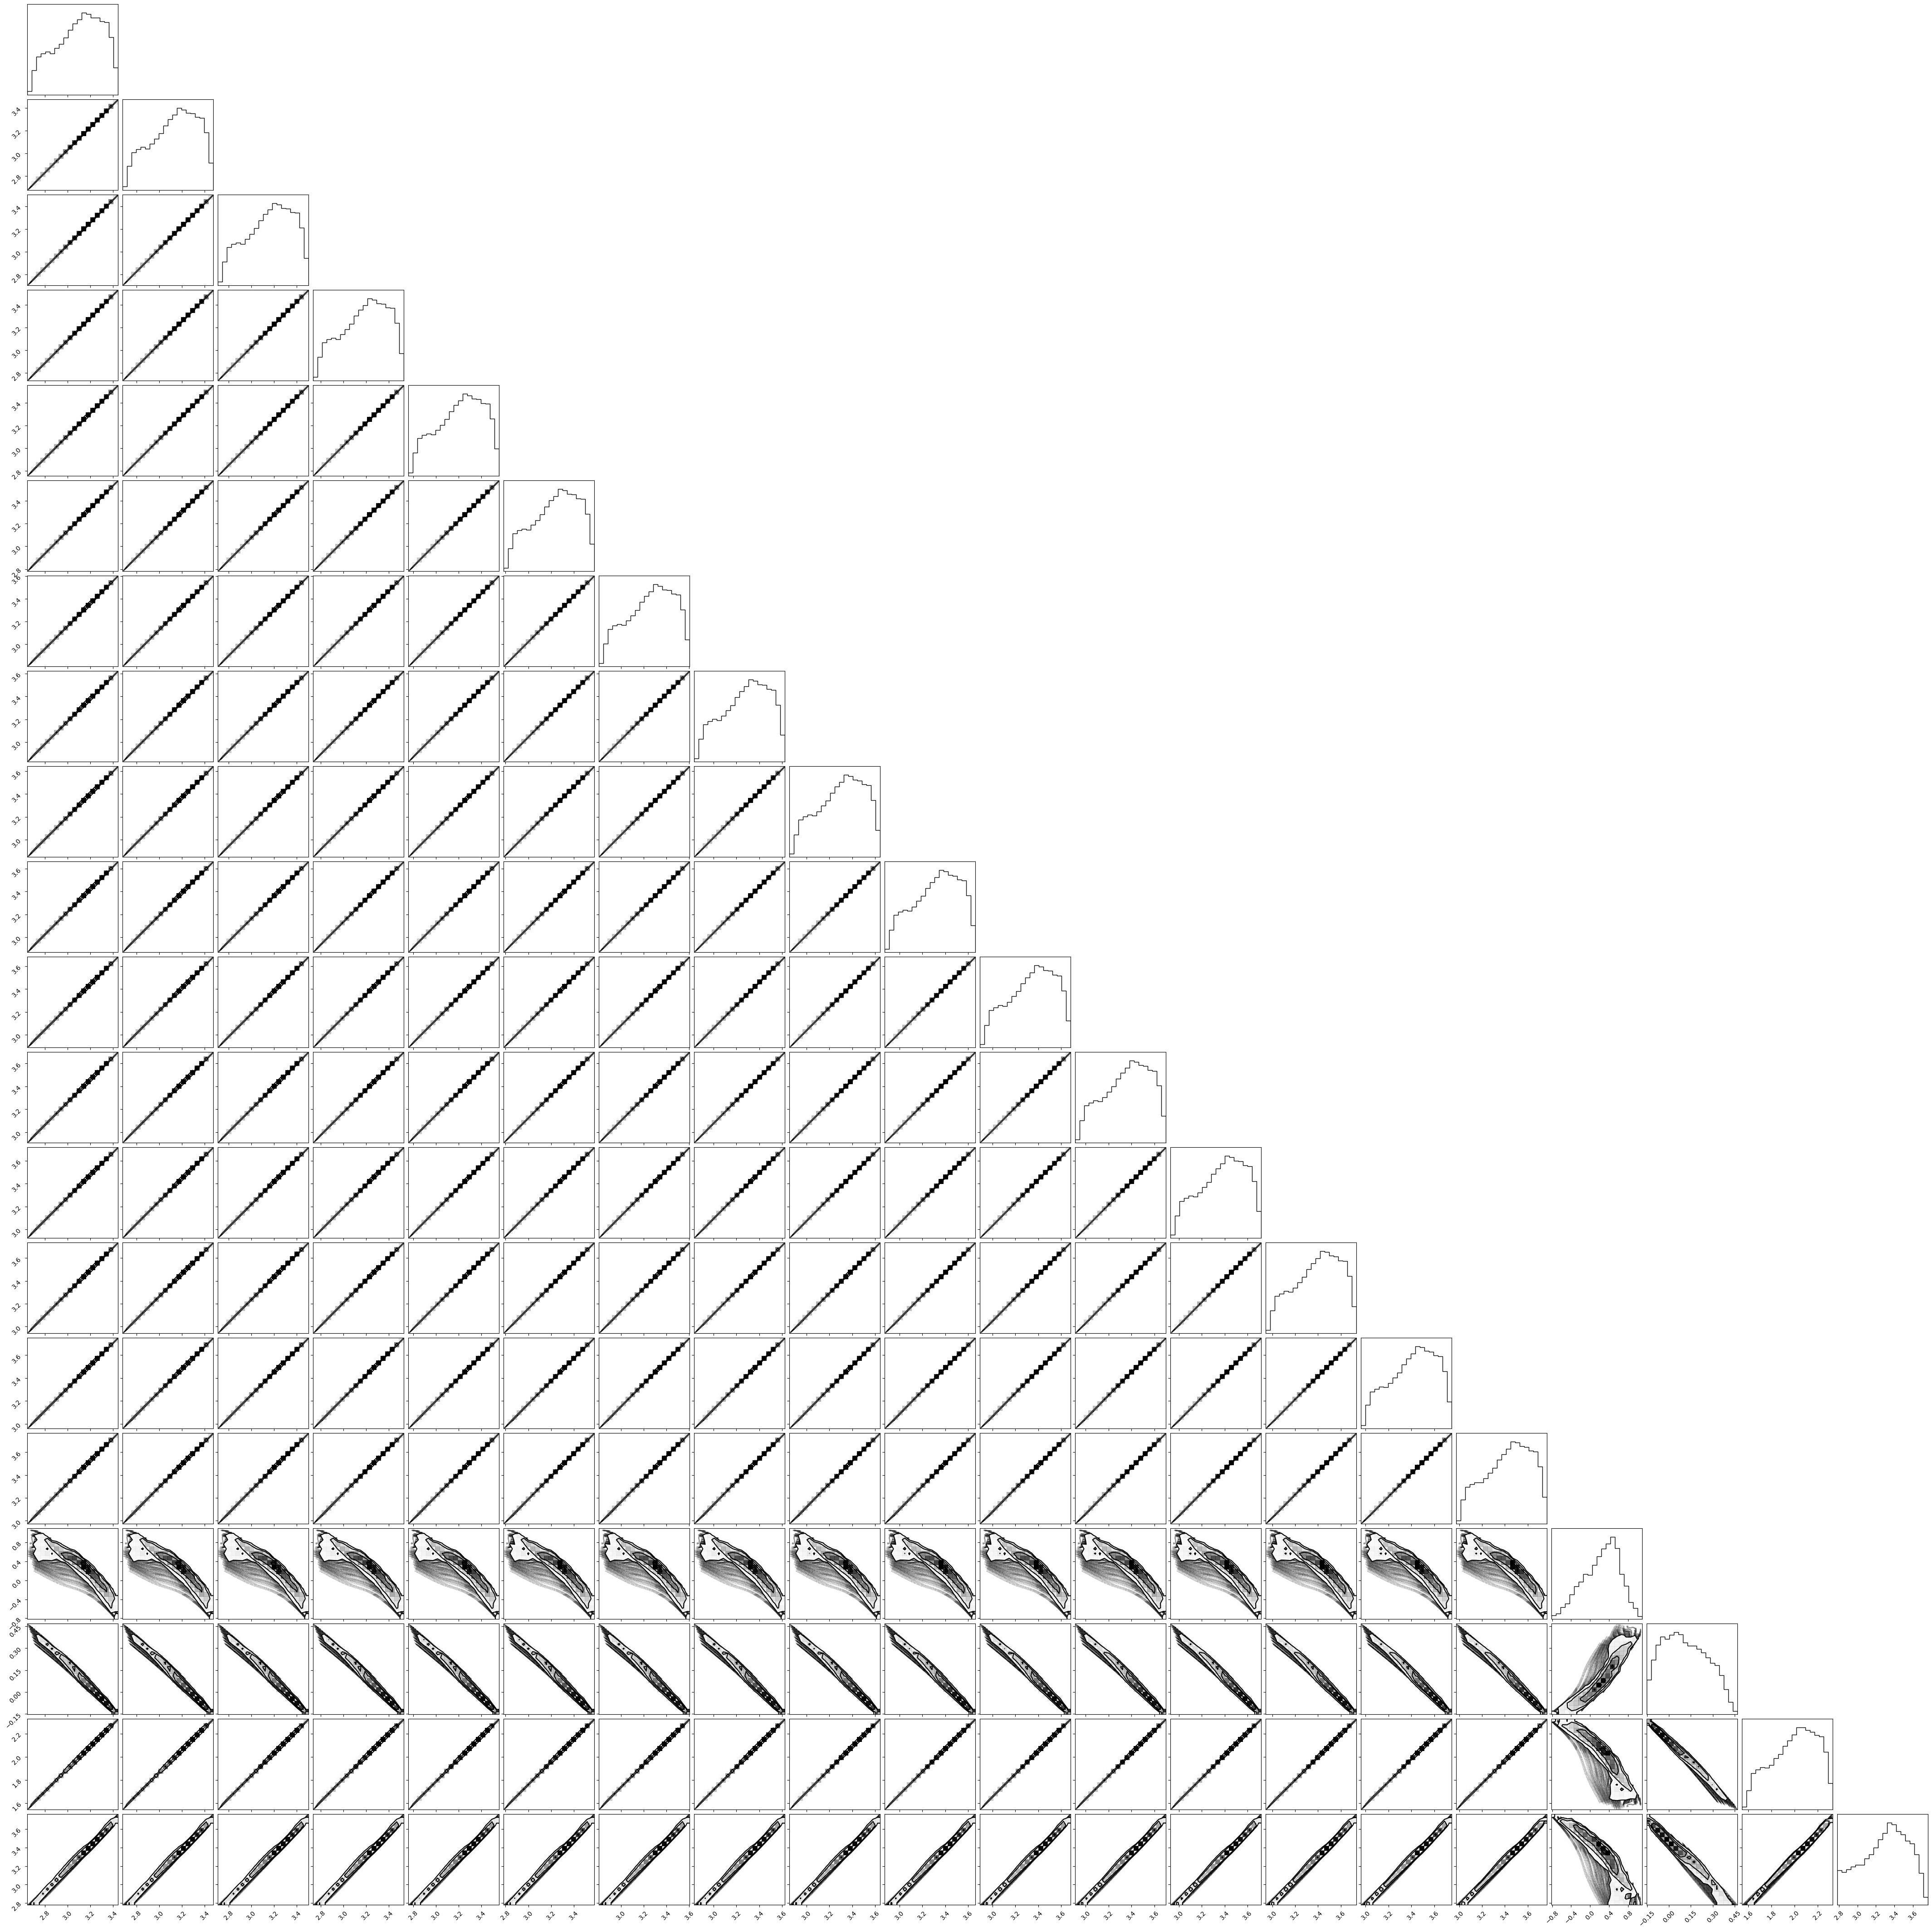

In [7]:
corner.corner(ys);

In [8]:
from functools import partial

class nn():
    def __init__(self, 
                 layer_sizes=[3, 5, 5, 2], 
                 key=random.PRNGKey(1)):
        self.params = self.initialize_mlp(layer_sizes, key)
        self.batch_forward = vmap(self.forward_pass, in_axes=(None, 0))
    
    def train(self, xs, ys, 
              lr=1e-1,
              epochs=100, 
              verbose=True,
              recompile=True):
        if recompile:
            self.initialize_opt(lr=lr)
        for i in range(epochs):
            grads = jax.grad(self.loss)(self.params, xs, ys)
            updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
            self.params = optax.apply_updates(self.params, updates)
            if i%(epochs / 10) == 0 and verbose:
                print(f'Epoch {i}: Loss is {self.loss(self.params, xs, ys)}')
        
    def initialize_opt(self, lr=2e-2):
        self.optimizer = optax.adam(lr, b1=0.999)
        #self.optimizer = optax.sgd(lr)
        self.opt_state = self.optimizer.init(self.params)
        
    def pred(self, params, x):
        return self.batch_forward(params, x)
        
    @partial(jit, static_argnums=(0,))
    def loss(self, params, x, y):
        preds = self.pred(params, x)
        loss = np.mean(optax.l2_loss(preds, y))
        return loss
        
    def forward_pass(self, params, x):
        """ Compute the forward pass for each example individually """
        activations = x

        # Loop over the hidden layers
        for w, b in params[:-1]:
            outputs = np.dot(w, activations) + b  # apply affine transformation
            activations = elu(outputs)  #  apply nonlinear activation

        # Perform final mlp output
        w, b = params[-1]
        outputs = (np.dot(w, activations) + b)
        
        return outputs
        
    def initialize_mlp(self, sizes, key):
        """ Initialize the weights of all layers of a linear layer network """
        keys = random.split(key, len(sizes))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, key, scale=1e-2):
            w_key, b_key = random.split(key)
            return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
        return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [9]:
nn = nn(layer_sizes = [len(icols), 64, 64, 64, 64, ys.shape[1]])

In [10]:
%%time
nn.train(np.asarray(xs), np.asarray(ys), lr=5e-4, epochs=2000)

Epoch 0: Loss is 4.707851409912109
Epoch 200: Loss is 0.43258169293403625
Epoch 400: Loss is 0.10225283354520798
Epoch 600: Loss is 0.05890010669827461
Epoch 800: Loss is 0.15432678163051605
Epoch 1000: Loss is 0.026410551741719246
Epoch 1200: Loss is 0.15280504524707794
Epoch 1400: Loss is 0.05382756143808365
Epoch 1600: Loss is 0.06946570426225662
Epoch 1800: Loss is 0.06971713155508041
CPU times: user 7min 35s, sys: 1min, total: 8min 35s
Wall time: 3min 12s


In [11]:
preds = nn.pred(nn.params, xs)

0.19757669
0.15363383293151855
0.15358591079711914
0.15302634239196777
0.15300965309143066
0.15313959121704102
0.15075445175170898
0.15205907821655273
0.15068650245666504
0.15052366256713867
0.14983010292053223
0.1499927043914795
0.14992594718933105
0.14929580688476562
0.14902019500732422
0.14946246147155762
0.14882278442382812
0.2530921697616577
0.13055741786956787
0.1533106565475464
0.1838212013244629


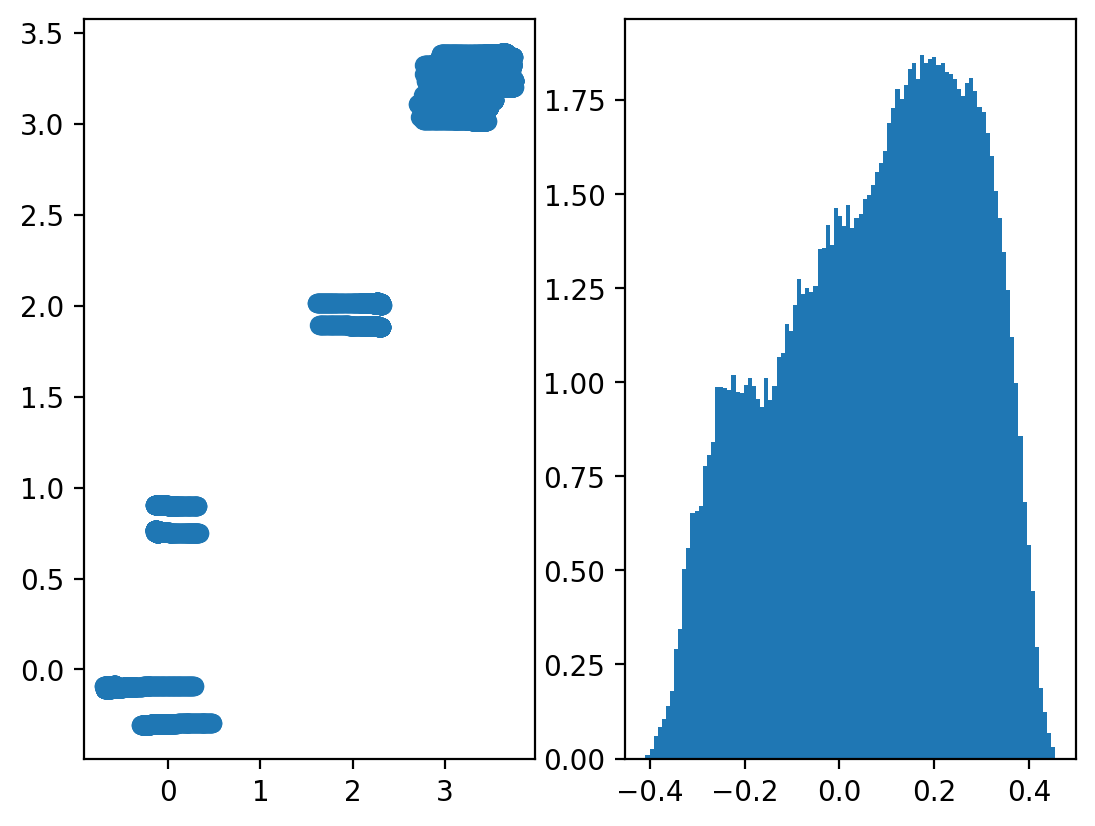

In [12]:
fig, ax = plt.subplots(1, 2, dpi=200)

n = 1000

ax[0].scatter(ys[:n, ...], preds[:n, ...])

ax[1].hist(onp.array(ys[:, 1] - preds[:, 1]), bins=100, density=True);
print(onp.std(onp.array(ys[:, 1] - preds[:, 1])))

from scipy import stats
for i in range(len(ys[0, :])):
    print(stats.median_abs_deviation(onp.array(ys[:, i] - preds[:, i])))

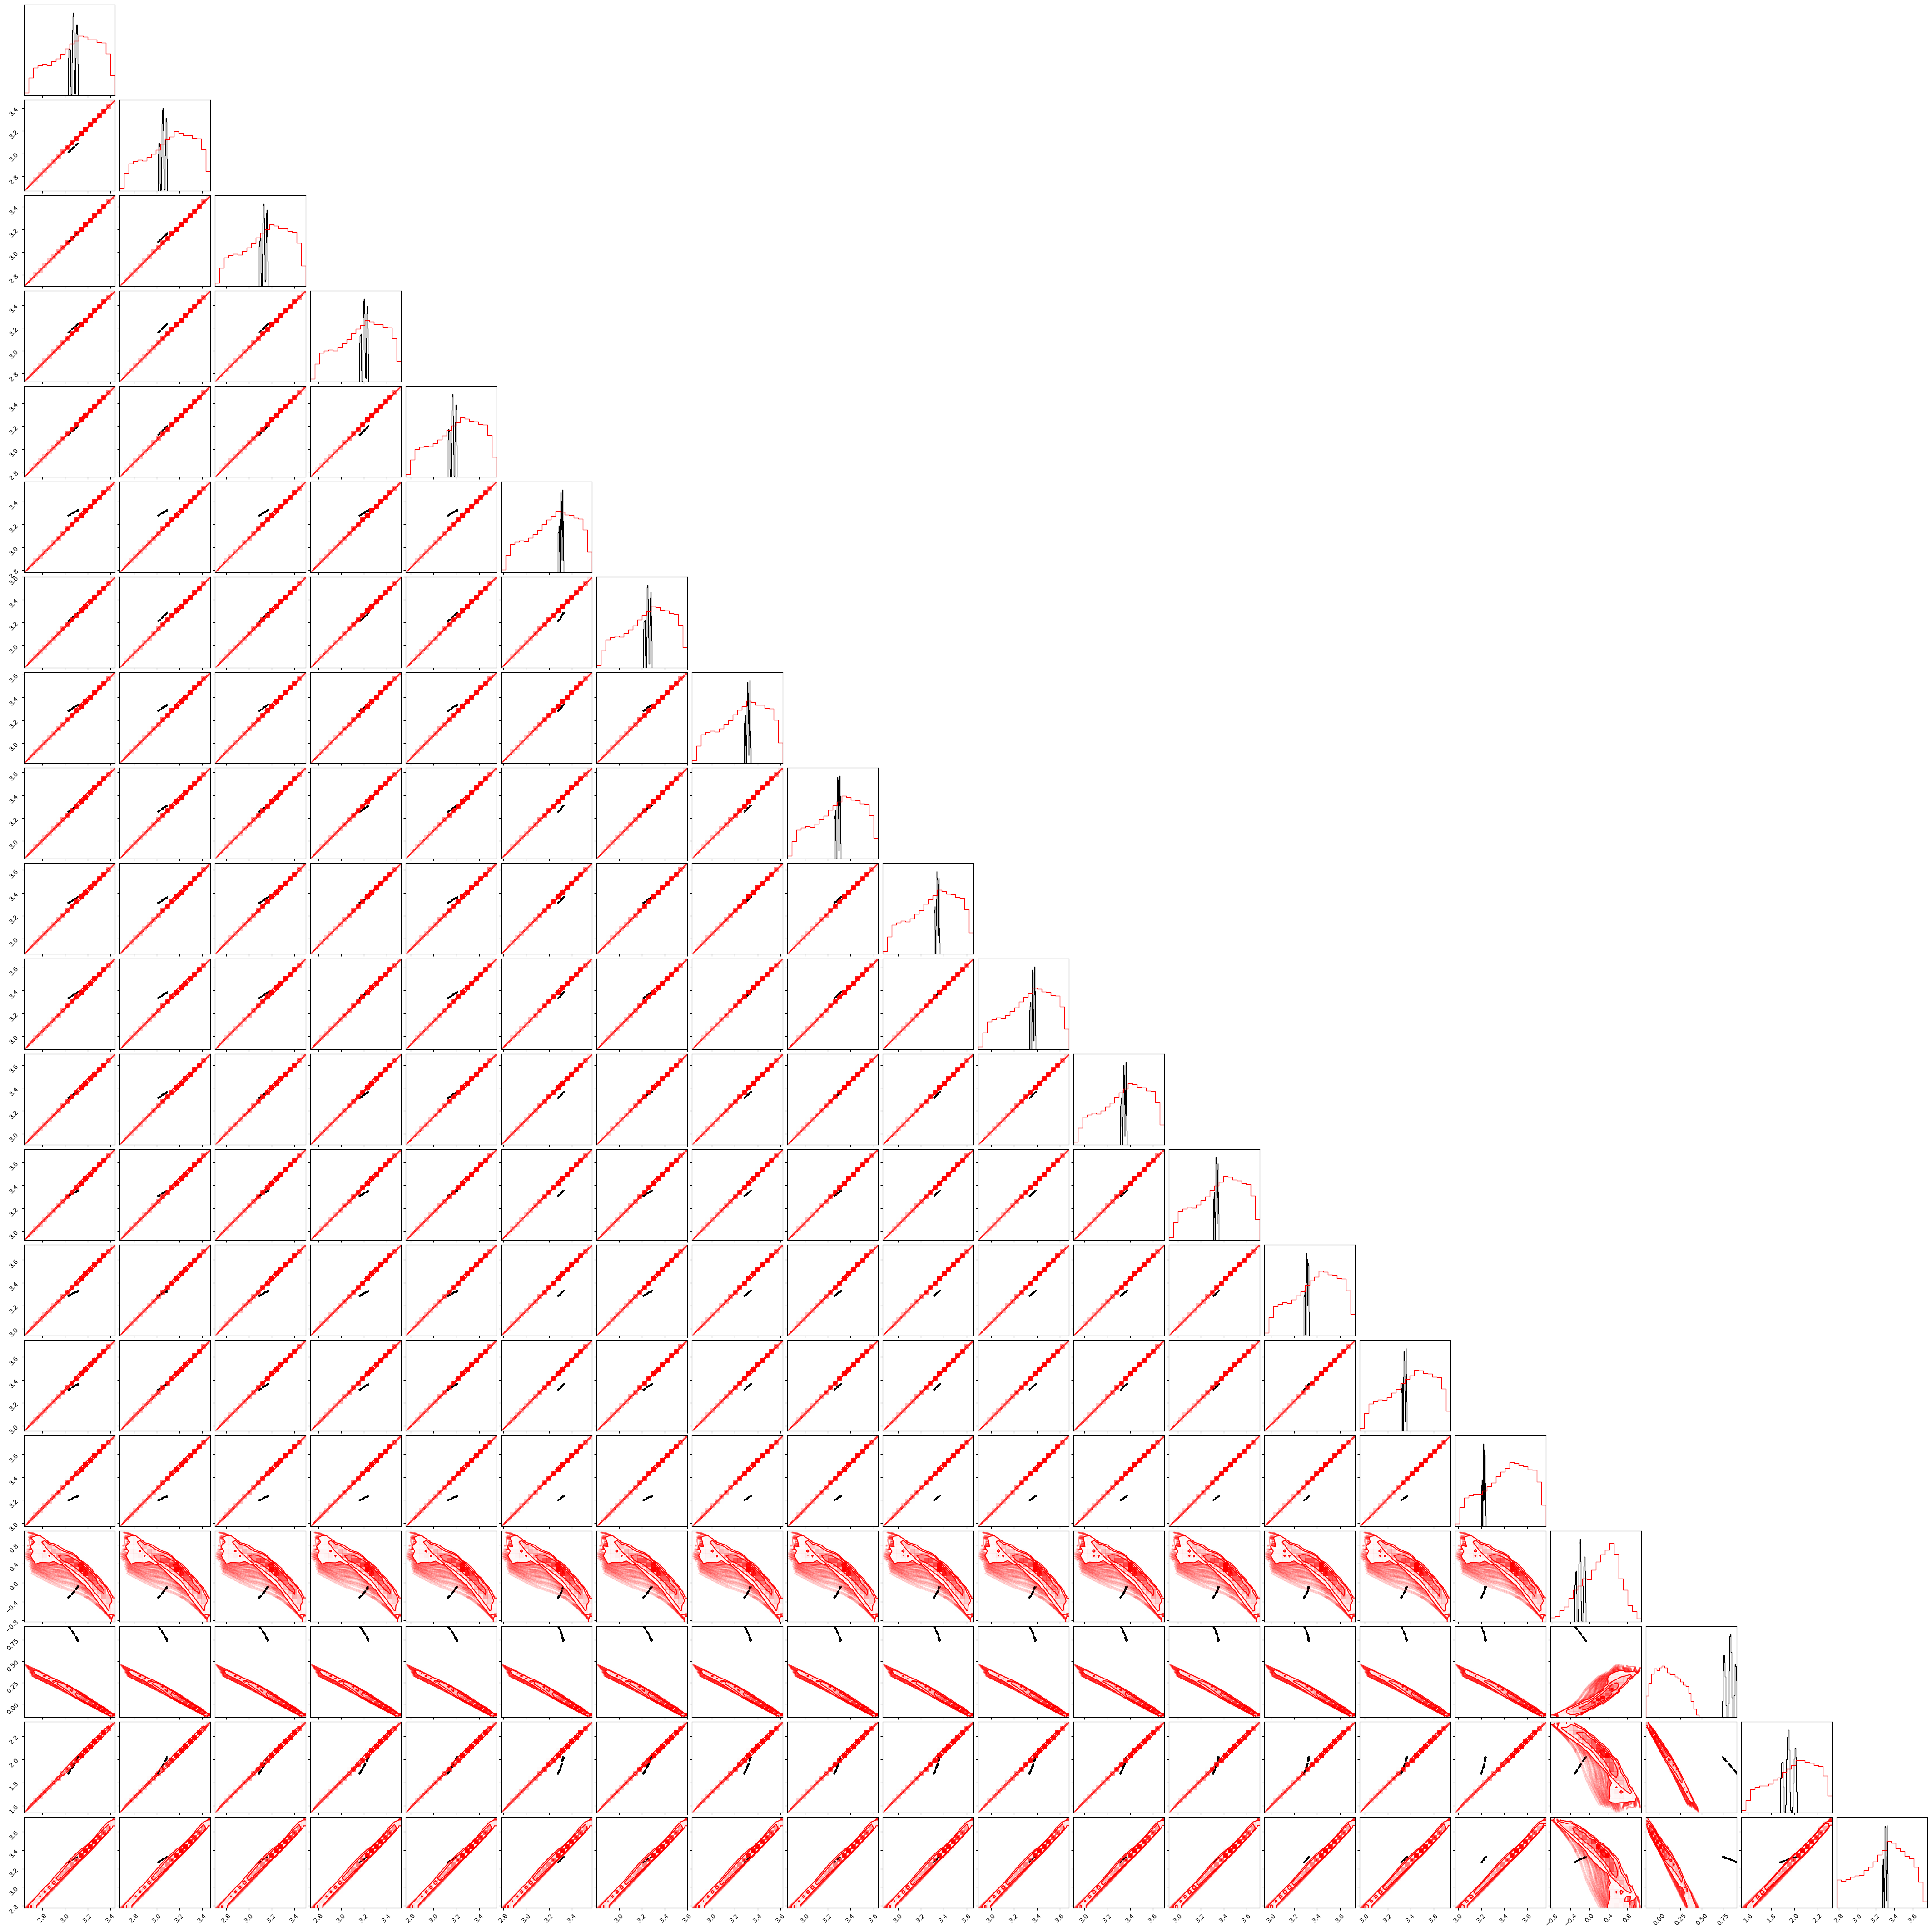

In [13]:
fig = corner.corner(onp.array(preds), color='k');
corner.corner(onp.array(ys), fig=fig, color='r');

In [14]:
nn.train(np.asarray(xs), np.asarray(ys), epochs=3000, recompile=False)

Epoch 0: Loss is 0.041274018585681915
Epoch 300: Loss is 0.04647156968712807
Epoch 600: Loss is 0.04472188651561737
Epoch 900: Loss is 0.028536062687635422
Epoch 1200: Loss is 0.02836279198527336
Epoch 1500: Loss is 0.021357860416173935
Epoch 1800: Loss is 0.015431536361575127
Epoch 2100: Loss is 0.01365142222493887
Epoch 2400: Loss is 0.012353336438536644
Epoch 2700: Loss is 0.009050945751369


In [15]:
print(nn.params)

[(DeviceArray([[ 9.42737684e-02, -3.42126191e-02, -9.26980749e-02,
              -3.21637169e-02,  1.58679888e-01],
             [-6.07479550e-02,  9.61842295e-03, -1.88255943e-02,
               4.59269388e-03, -5.96227348e-02],
             [-9.17839929e-02,  3.50762461e-03,  5.59114404e-02,
               1.57191046e-02, -9.59063247e-02],
             [-1.19412743e-01, -2.75843986e-03,  8.53654370e-02,
               1.75015721e-02, -2.01818317e-01],
             [-1.33325219e-01,  1.84825454e-02,  8.70936587e-02,
               2.44211257e-02, -1.71048537e-01],
             [ 7.94906691e-02,  2.59709265e-03, -7.47317309e-03,
              -1.31886685e-02,  6.85518235e-02],
             [ 2.65981276e-02,  6.91454485e-03,  2.17142448e-01,
               1.36779277e-02, -5.25068380e-02],
             [-1.02303743e-01,  7.65625434e-03,  7.80325159e-02,
               2.72663664e-02, -1.96836427e-01],
             [-9.55398753e-02,  3.74287076e-04,  8.99581984e-03,
               1.0402

[0.8        0.32       0.5        2.1        0.00986245]


(6400.0, 5000.0)

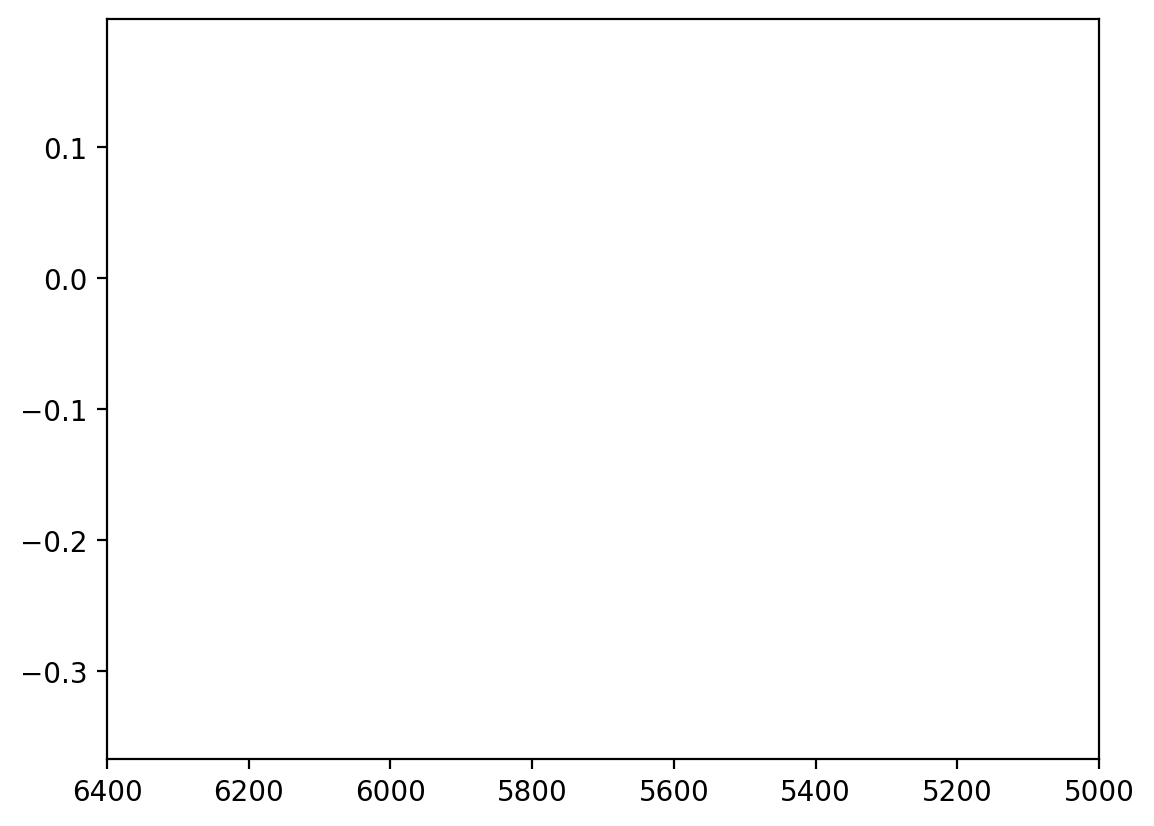

In [17]:
print(xs[0, :])
fage = onp.arange(0, 1.1, 0.001)
fig, ax = plt.subplots(dpi=200)

for m in np.arange(0.8, 1.2, 0.02):
    isoinput = [[m, 0.27, 0.0, 2.1, n] for n in fage]
    isochrone = nn.pred(nn.params, np.asarray(isoinput))


    ax.scatter(10**(isochrone[:, -4]), isochrone[:, -3], c=fage)
ax.set_xlim([6400, 5000])